In [33]:
from astropy.io import fits
from sklearn.decomposition import FastICA, PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Load Data

In [34]:
with open('Load_Harps_complete/preproc/preproc/Preproc_flux.pkl', 'rb') as file:
    flux = pickle.load(file)
print(flux.shape) # transpose to O, S, P
flux = flux.swapaxes(0, 1)
flux.shape

(838, 69, 4096)


(69, 838, 4096)

### Focusing on a single observation and order

In [35]:
order_idx = 54

X = flux[order_idx, :, :]
X.shape

(838, 4096)

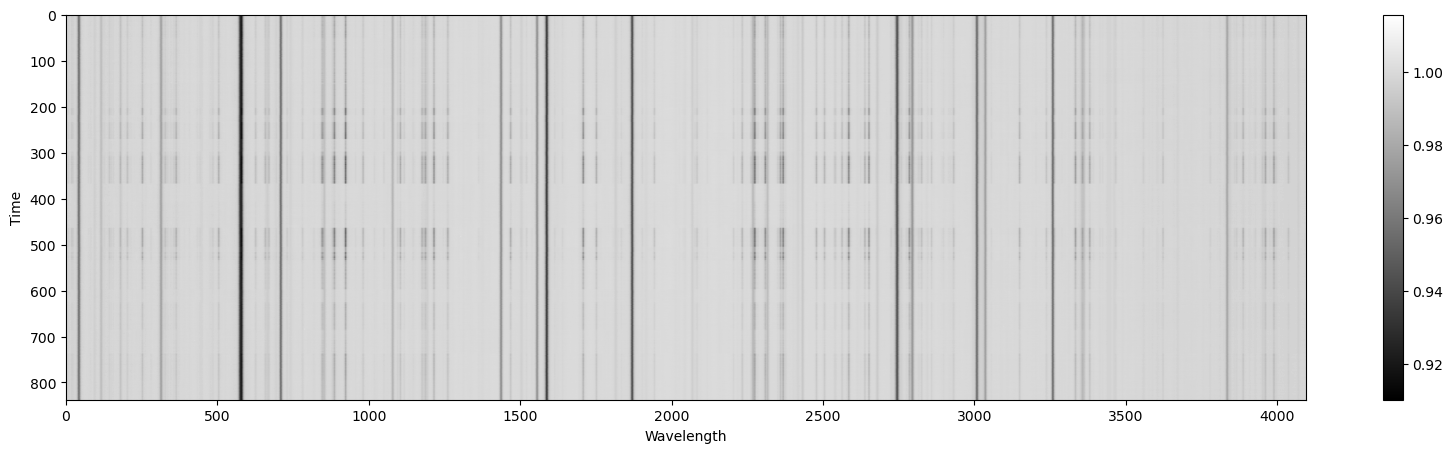

In [36]:
# display the image
fig, ax = plt.subplots(figsize=(20, 5))
im = ax.imshow(X, cmap='gray', aspect='auto')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Time') # ??

# add colorbar
fig.colorbar(im)

### Preprocessing procedure
- **Logarithmic transformation**
- **Median normalization**
- **Standardization**

In [37]:
# X[np.isfinite(X) == 0] = np.finfo(np.float64).eps 
# X[np.where(X <= 0)] = np.finfo(np.float64).eps
# X = X.log10()


X[np.where(np.isfinite(X) == 0)] = np.finfo(np.float64).eps 
X[np.where(X <= 1)] = np.finfo(np.float64).eps
X = np.log10(X)

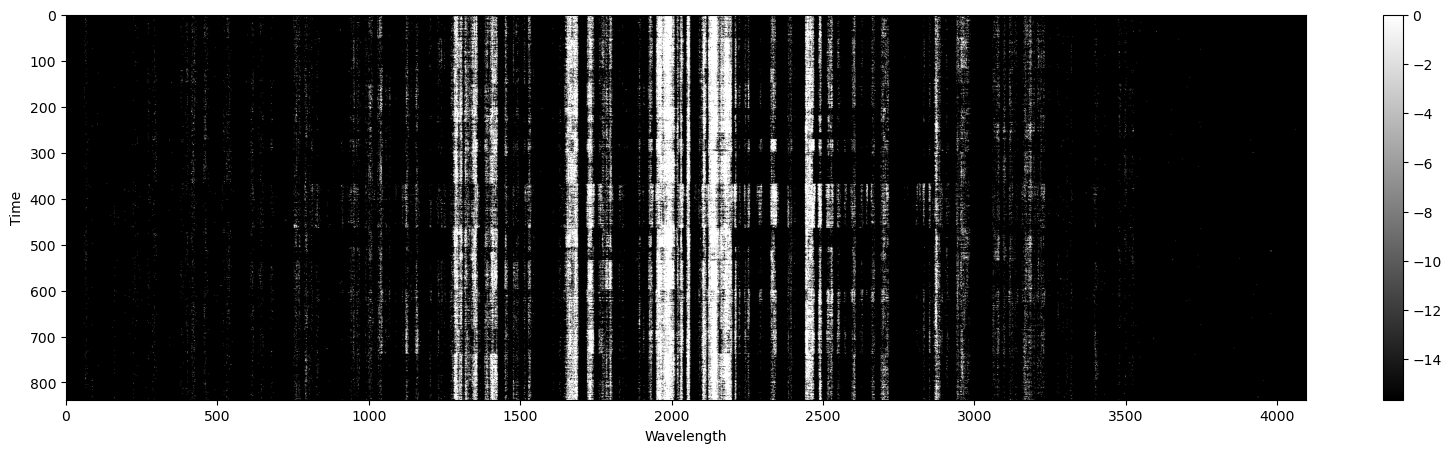

In [38]:
# display the image
fig, ax = plt.subplots(figsize=(20, 5))
im = ax.imshow(X, cmap='gray', aspect='auto')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Time')

# add colorbar
fig.colorbar(im)

In [39]:
medians = np.median(X, axis=1)[:, np.newaxis]
X /= medians
# X -= medians

In [40]:
means = np.mean(X, axis=0)
X -= means

In [41]:
stddevs = np.std(X, axis=1)[:, np.newaxis]
X /= stddevs
X.shape

(838, 4096)

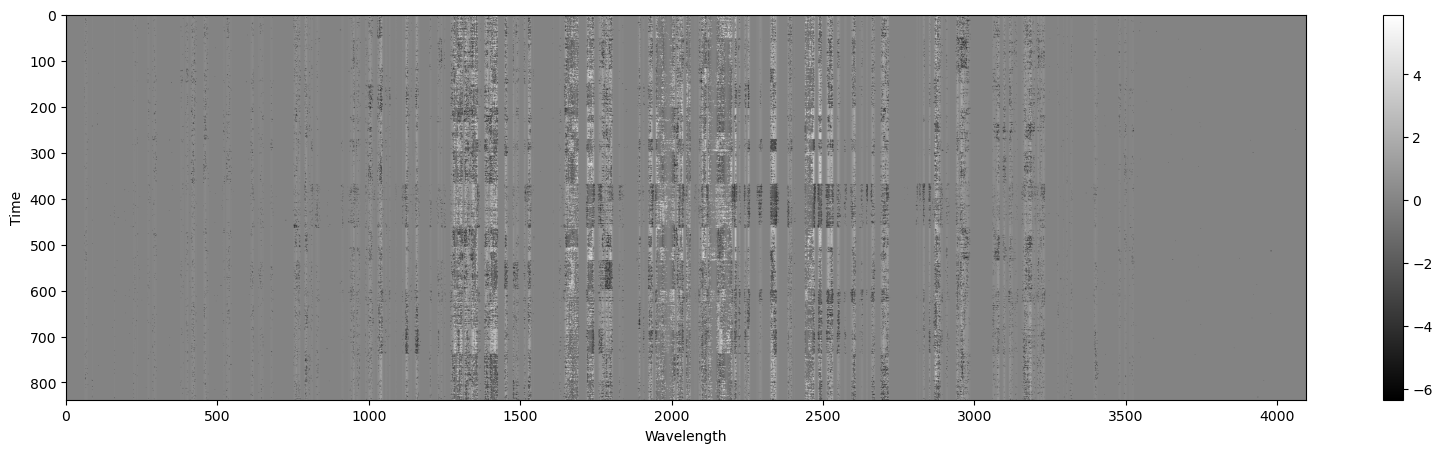

In [42]:
# display the image
fig, ax = plt.subplots(figsize=(20, 5))
im = ax.imshow(X, cmap='gray', aspect='auto')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Time')

# add colorbar
fig.colorbar(im)

### Blind Source Separation: FastICA

In [43]:
ica = FastICA(n_components=4, max_iter=1000, whiten='unit-variance')


In [44]:
S_ = ica.fit_transform(X.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
# assert np.allclose(X.T, ica.inverse_transform(S_))  (True, if n_components=None)

In [45]:
S_.shape

(4096, 4)

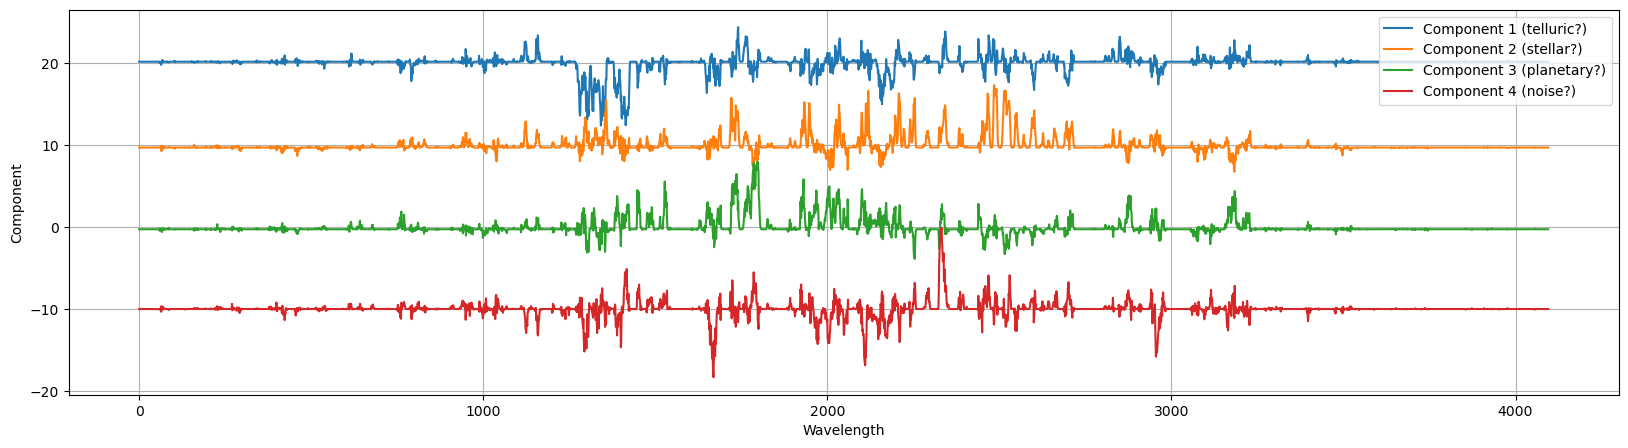

In [46]:
# display the image
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.arange(S_.shape[0]), S_.T[0, :] + 20, label='Component 1 (telluric?)')
ax.plot(np.arange(S_.shape[0]), S_.T[1, :] + 10, label='Component 2 (stellar?)')
ax.plot(np.arange(S_.shape[0]), S_.T[2, :], label='Component 3 (planetary?)')
ax.plot(np.arange(S_.shape[0]), S_.T[3, :] - 10, label='Component 4 (noise?)')
# ax.plot(np.arange(S_.shape[0]), S_.T[4, :] - 20, label='Component 5 (noise?)')
plt.grid(True)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Component')
ax.legend()

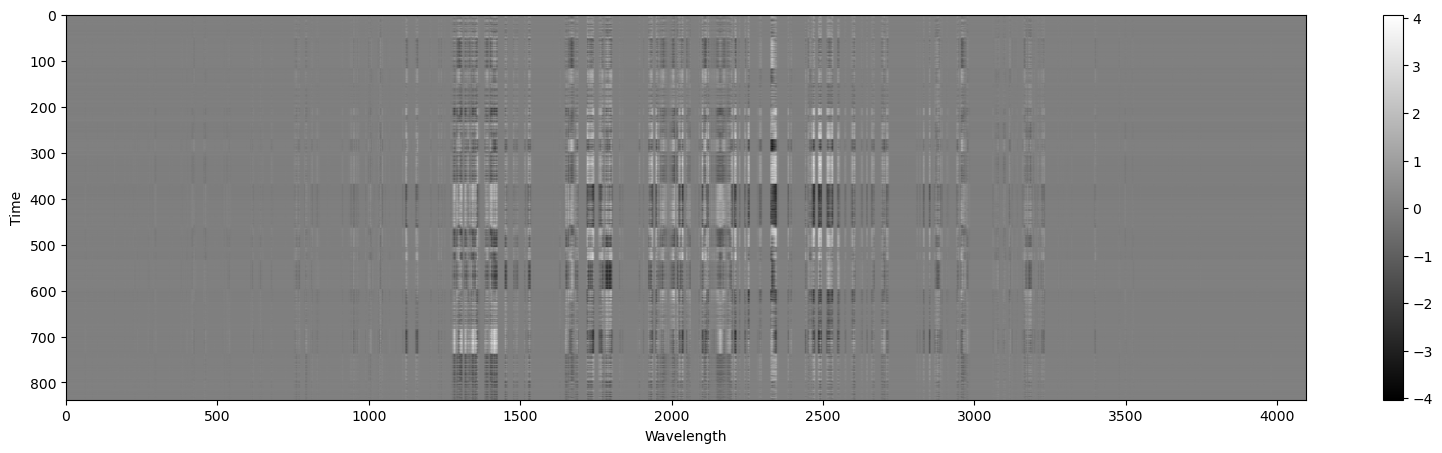

In [47]:
# plot the inverse transform
fig, ax = plt.subplots(figsize=(20, 5))
im = ax.imshow(ica.inverse_transform(S_).T, cmap='gray', aspect='auto')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Time')

# add colorbar
fig.colorbar(im)

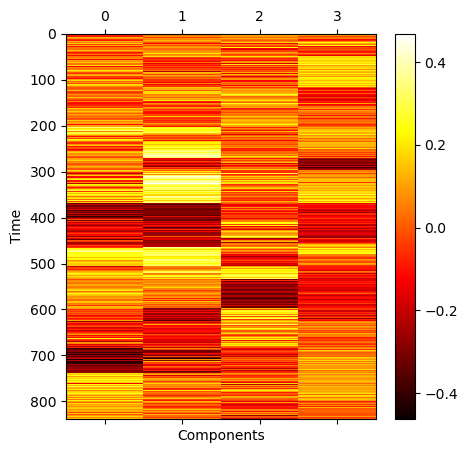

In [48]:
# plot the mixing matrix
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.matshow(A_, cmap='hot', aspect='auto')
ax.set_xlabel('Components')
ax.set_ylabel('Time')

# add colorbar
fig.colorbar(im)

### Measure the distance between original spectra and ICA reconstructions

In [49]:
np.mean((X - ica.inverse_transform(S_).T) ** 2)

0.8996142035902728

In [50]:
np.sqrt(np.mean((X - ica.inverse_transform(S_).T) ** 2))

0.9484799436942633

### Plot original, preprocessed, reconstructed and residual spectra

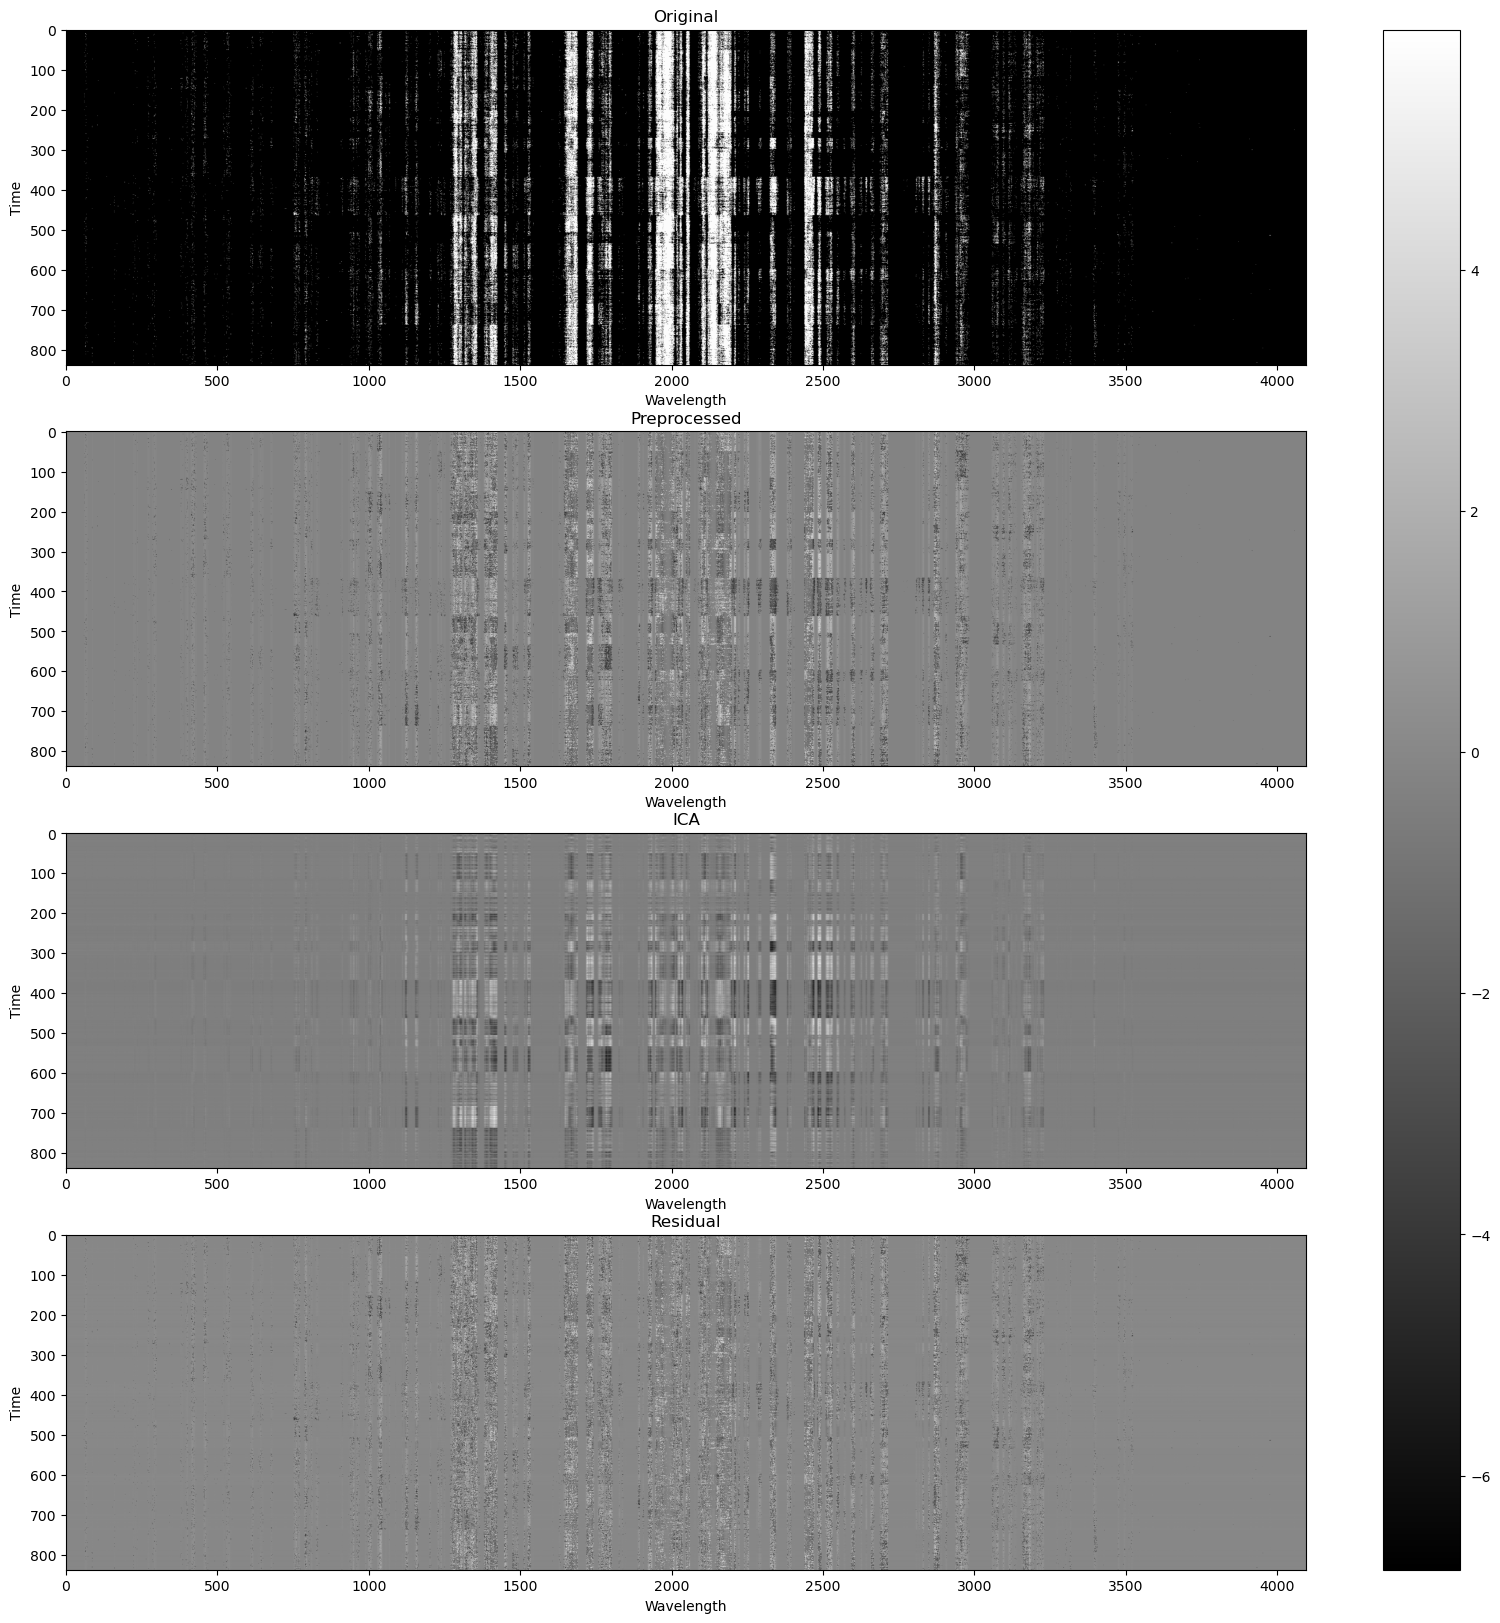

In [51]:
# plot the inverse transform
fig, ax = plt.subplots(figsize=(20, 20), nrows=4, ncols=1)

im = ax[0].imshow(flux[order_idx, :, :], cmap='gray', aspect='auto')
ax[0].set_title('Original')
ax[0].set_xlabel('Wavelength')
ax[0].set_ylabel('Time')

im = ax[1].imshow(X, cmap='gray', aspect='auto')
ax[1].set_title('Preprocessed')
ax[1].set_xlabel('Wavelength')
ax[1].set_ylabel('Time')

im = ax[2].imshow(ica.inverse_transform(S_).T, cmap='gray', aspect='auto')
ax[2].set_title('ICA')
ax[2].set_xlabel('Wavelength')
ax[2].set_ylabel('Time')

im = ax[3].imshow(X - ica.inverse_transform(S_).T, cmap='gray', aspect='auto')
ax[3].set_title('Residual')
ax[3].set_xlabel('Wavelength')
ax[3].set_ylabel('Time')

# add colorbar
fig.colorbar(im, ax=ax.ravel().tolist())

### Compute the RMSE of the residual

In [52]:
np.sqrt(np.mean((X - ica.inverse_transform(S_).T) ** 2))

0.9484799436942633

### Statistics

In [53]:
print(np.min(flux[order_idx, :, :]), np.max(flux[order_idx, :, :]))
print(np.min(X), np.max(X))
print(np.min(ica.inverse_transform(S_).T), np.max(ica.inverse_transform(S_).T))
print(np.min(X - ica.inverse_transform(S_).T), np.max(X - ica.inverse_transform(S_).T))

2.220446049250313e-16 1.0156566523569173
-6.348887710268883 5.901996615612704
-4.0311910313136785 4.068187785464723
-6.780400562560049 5.990334694348589


### Plot a single in-transit spectrum

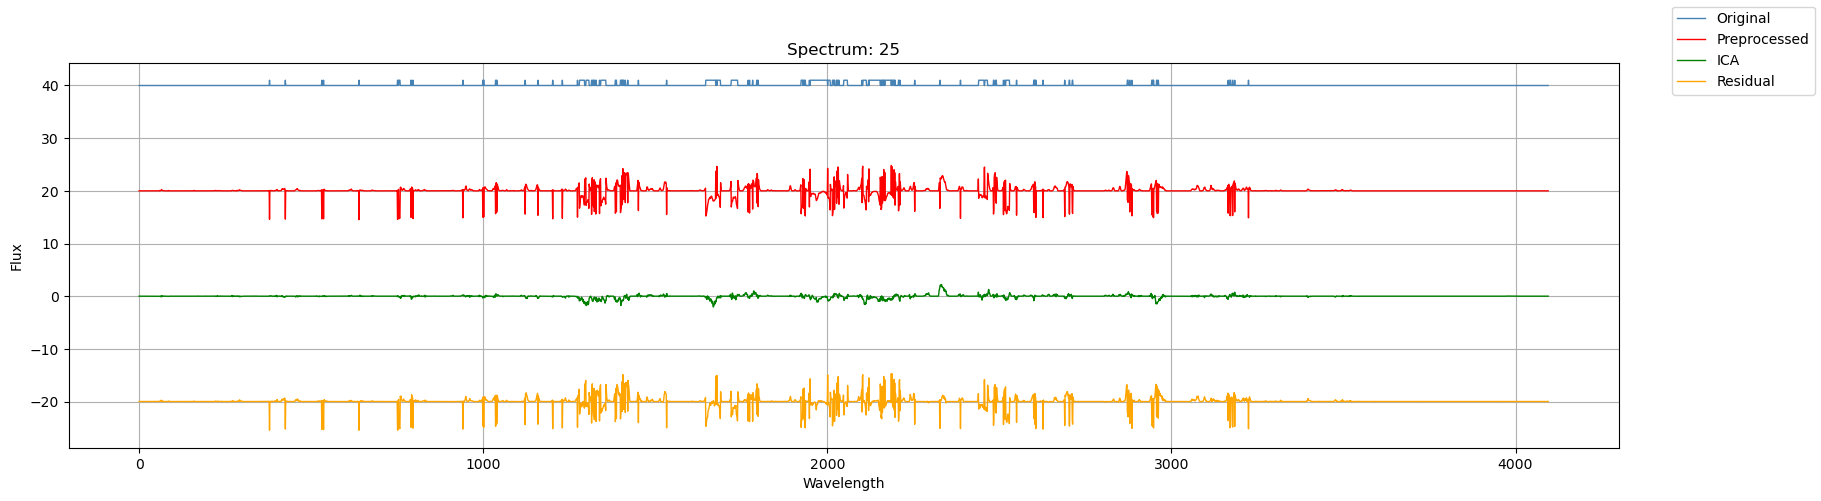

In [54]:
# plot a single spectrum
colors = ["red", "steelblue", "orange"]
index = 25

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.arange(X.shape[1]), flux[order_idx, index, :] + 40, color='steelblue', label='Original', linewidth=1)
ax.plot(np.arange(X.shape[1]), X[index, :] + 20, color='red', label='Preprocessed', linewidth=1)
ax.plot(np.arange(X.shape[1]), ica.inverse_transform(S_).T[index, :], color='green', label='ICA', linewidth=1)
ax.plot(np.arange(X.shape[1]), X[index, :] - ica.inverse_transform(S_).T[index, :] - 20, color='orange', label='Residual', linewidth=1)

ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_title(f'Spectrum: {index}')
plt.grid()
fig.legend()

### Writing a routine for picking the best _n_components_

In [58]:
rmse = [np.inf]

for comp_i in range(1, X.shape[0] - 1):
    if comp_i % 50 == 0:
        print(f"Processing for n_components = {comp_i}")
    ica = FastICA(n_components=comp_i, max_iter=400, whiten='unit-variance')
    S_ = ica.fit_transform(X.T)  # Reconstruct signals
    
    rmse.append(np.sqrt(np.mean((X - ica.inverse_transform(S_).T) ** 2)))
    
rmse = np.array(rmse)
np.argmin(rmse), rmse[np.argmin(rmse)]

Processing for 50
Processing for 100
Processing for 150
Processing for 200
Processing for 250
Processing for 300
Processing for 350
Processing for 400
Processing for 450


KeyboardInterrupt: 

In [61]:
rmse

array([0.85937772, 0.82033854, 0.79857461, 0.78030949, 0.76245197,
       0.74508655, 0.72839926, 0.71295151, 0.69724961, 0.68154189,
       0.66582836, 0.65019225, 0.63508661, 0.61975503, 0.60484094,
       0.59004382, 0.5752854 , 0.56026864, 0.54552892, 0.53064584,
       0.51590954, 0.50097694, 0.48583724, 0.47063307, 0.4554318 ,
       0.44007348, 0.42453961, 0.40886972, 0.39304199, 0.3768559 ,
       0.36040332, 0.34368265, 0.32662502, 0.30906351, 0.29085476,
       0.27197382, 0.25217498, 0.23089226, 0.20856568, 0.18467469,
       0.15774767, 0.12624965, 0.08676082])

In [62]:
diff = []
for a, b in zip(rmse[:-1], rmse[1:]):
    diff.append(np.abs((a - b)))
diff = np.array(diff)
diff

array([0.03903917, 0.02176393, 0.01826512, 0.01785752, 0.01736542,
       0.01668729, 0.01544775, 0.01570189, 0.01570772, 0.01571353,
       0.01563611, 0.01510564, 0.01533158, 0.01491408, 0.01479712,
       0.01475842, 0.01501675, 0.01473972, 0.01488308, 0.0147363 ,
       0.0149326 , 0.0151397 , 0.01520417, 0.01520126, 0.01535832,
       0.01553388, 0.01566988, 0.01582773, 0.01618609, 0.01645259,
       0.01672067, 0.01705763, 0.01756151, 0.01820875, 0.01888094,
       0.01979884, 0.02128272, 0.02232658, 0.02389099, 0.02692703,
       0.03149802, 0.03948883])

In [63]:
n_comps = np.where(diff < np.sort(diff)[int(.05 * diff.shape[0])])[0][0] + 1
n_comps

18

In [64]:
ica = FastICA(n_components=n_comps, max_iter=1000, whiten='unit-variance')
S_ = ica.fit_transform(X.T)  # Reconstruct signals

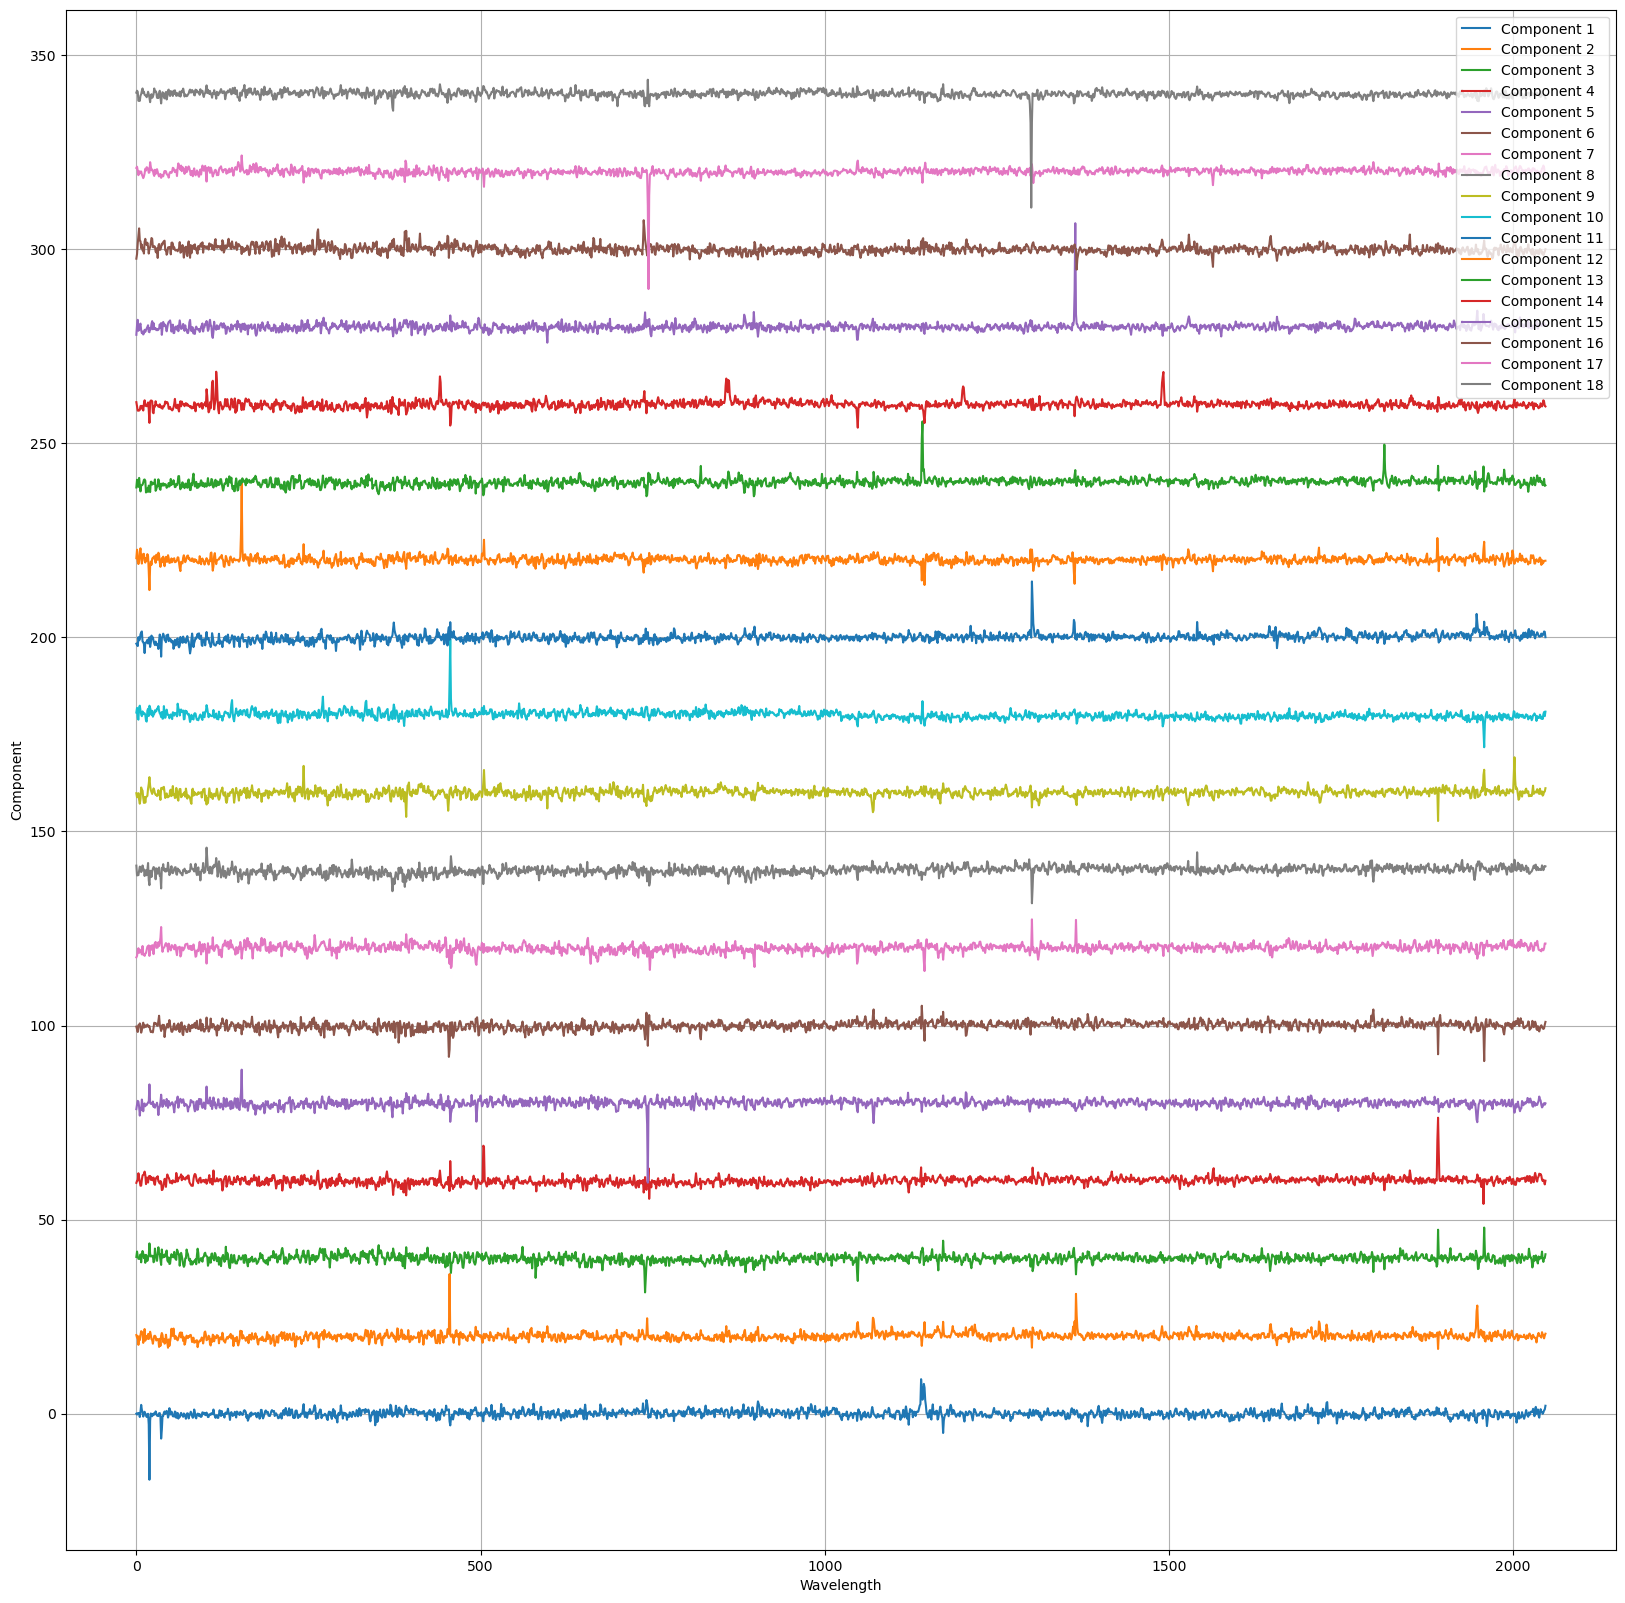

In [65]:
# display the image
fig, ax = plt.subplots(figsize=(20, 20))
for i in range(S_.shape[1]):
    ax.plot(np.arange(2048), S_.T[i, :] + 20 * i, label=f'Component {i + 1}')
plt.grid(True)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Component')
ax.legend()

In [66]:
np.sqrt(np.mean((X - ica.inverse_transform(S_).T) ** 2))

0.5752853962480104

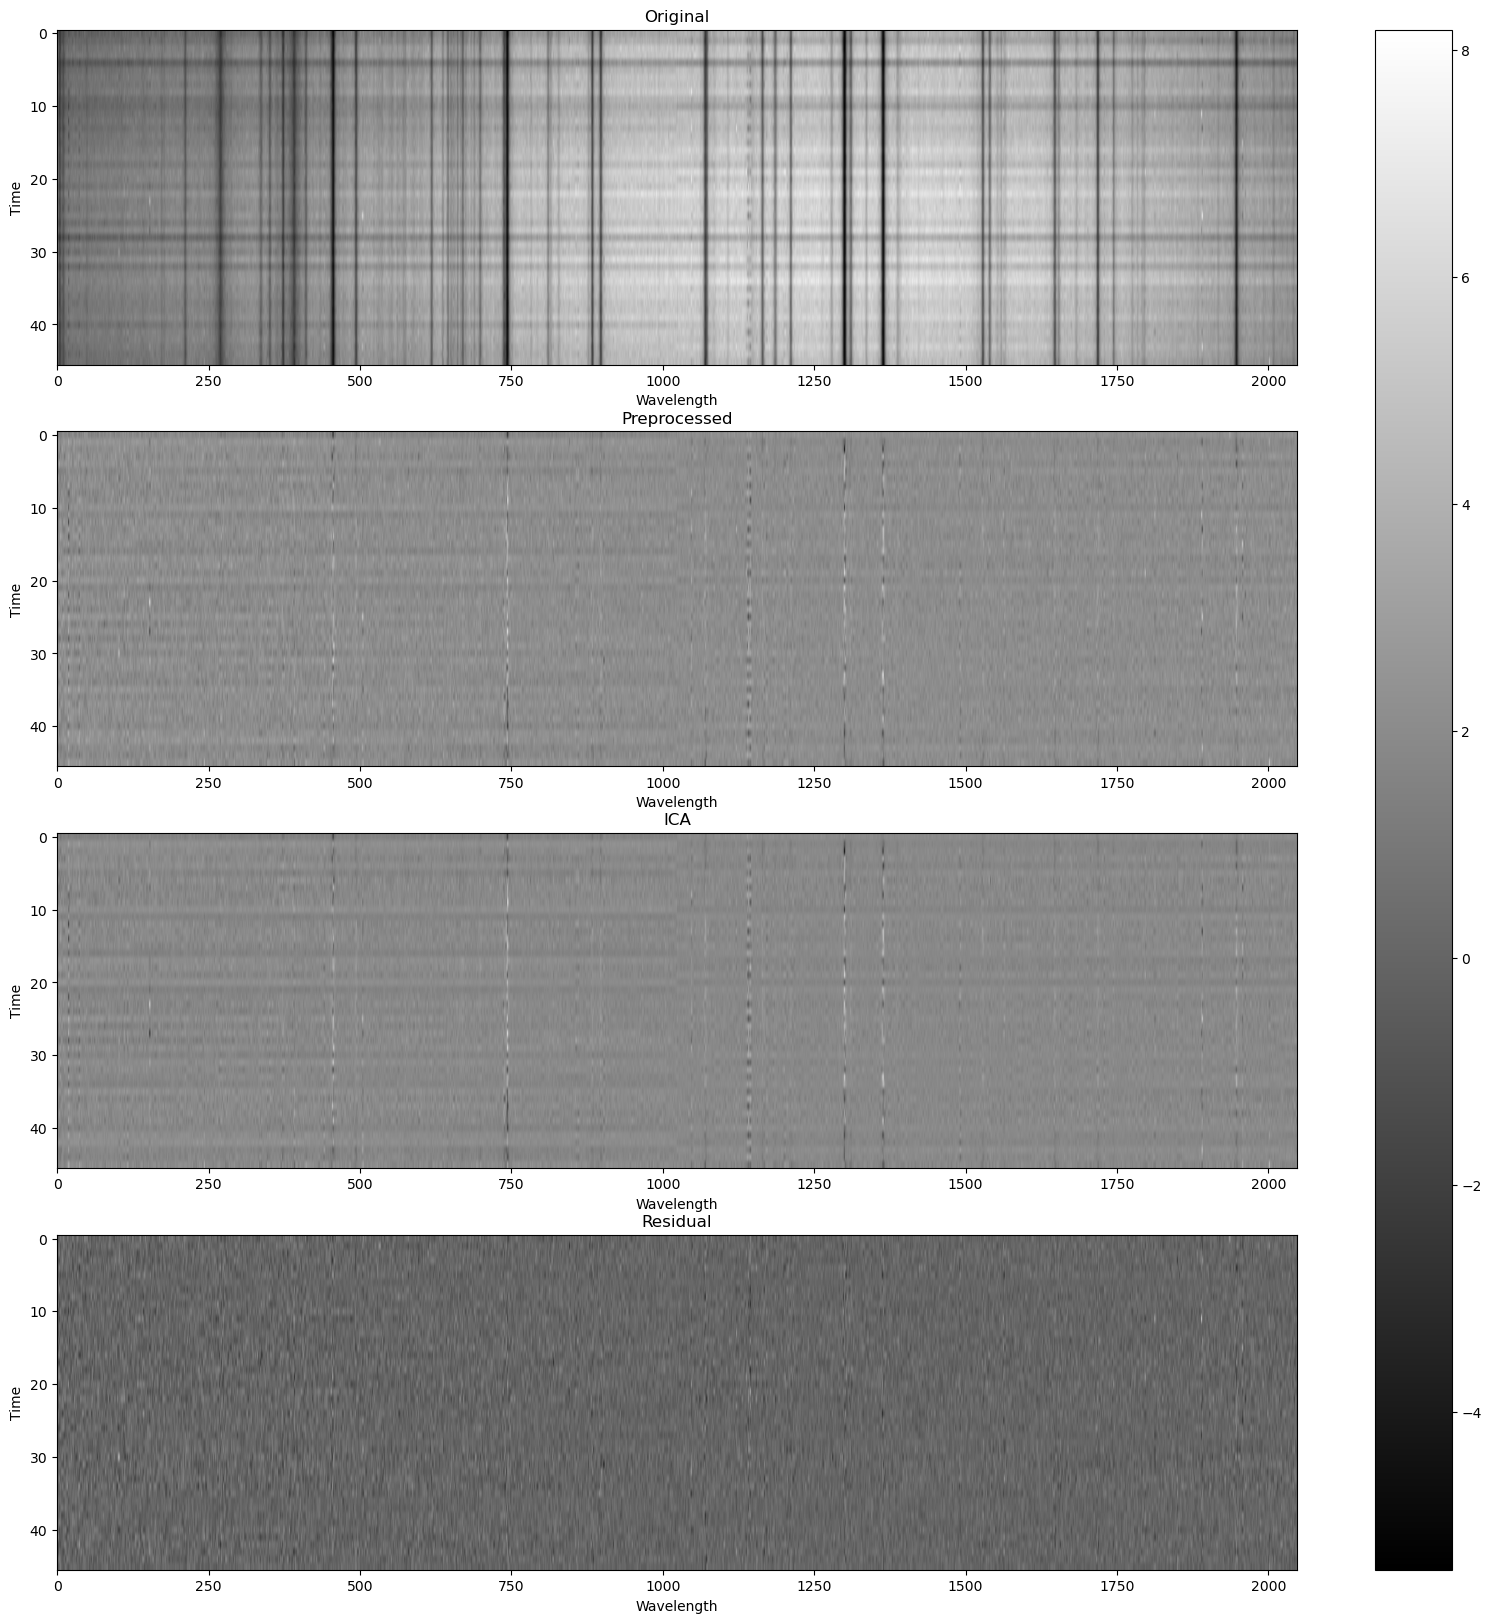

In [67]:
# plot the inverse transform
fig, ax = plt.subplots(figsize=(20, 20), nrows=4, ncols=1)

im = ax[0].imshow(data[order_idx, :, :], cmap='gray', aspect='auto')
ax[0].set_title('Original')
ax[0].set_xlabel('Wavelength')
ax[0].set_ylabel('Time')

im = ax[1].imshow(X, cmap='gray', aspect='auto')
ax[1].set_title('Preprocessed')
ax[1].set_xlabel('Wavelength')
ax[1].set_ylabel('Time')

im = ax[2].imshow(ica.inverse_transform(S_).T, cmap='gray', aspect='auto')
ax[2].set_title('ICA')
ax[2].set_xlabel('Wavelength')
ax[2].set_ylabel('Time')

im = ax[3].imshow(X - ica.inverse_transform(S_).T, cmap='gray', aspect='auto')
ax[3].set_title('Residual')
ax[3].set_xlabel('Wavelength')
ax[3].set_ylabel('Time')

# add colorbar
fig.colorbar(im, ax=ax.ravel().tolist())

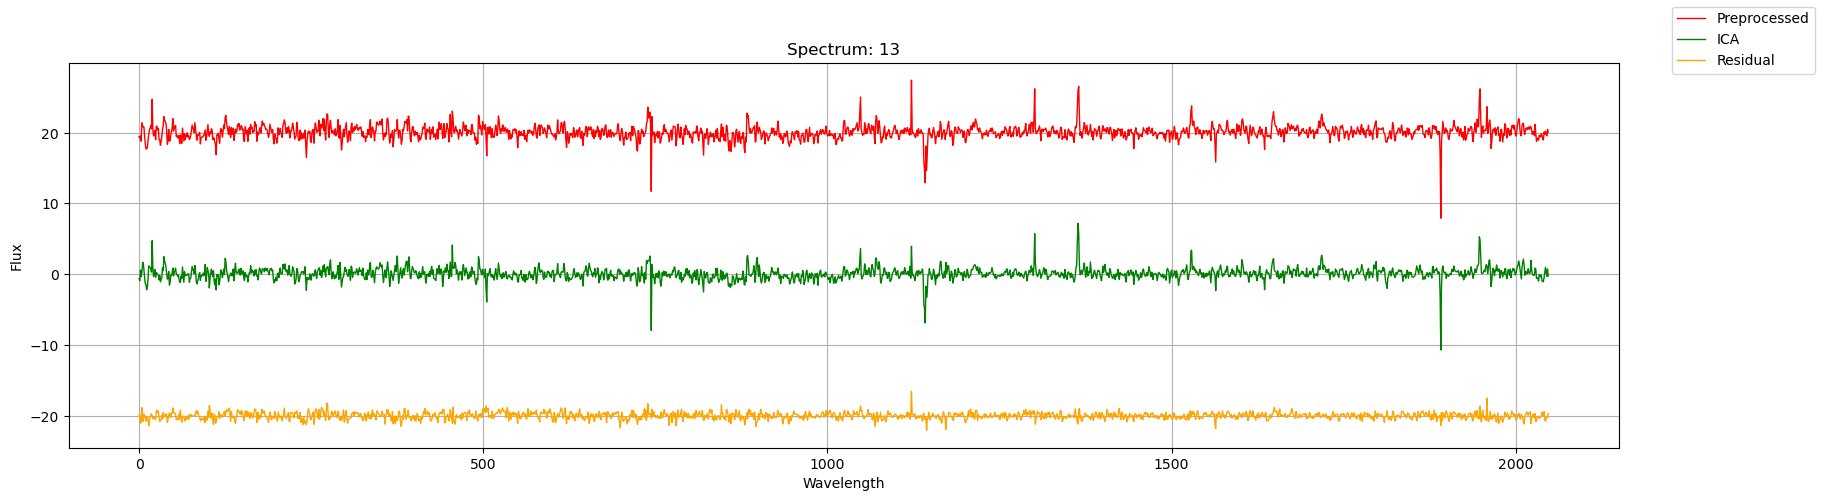

In [68]:
# plot a single spectrum
colors = ["red", "steelblue", "orange"]
index = 13

fig, ax = plt.subplots(figsize=(20, 5))
# ax.plot(np.arange(2048), data[order_idx, index, :] + 40, color='steelblue', label='Original', linewidth=1)
ax.plot(np.arange(2048), X[index, :] + 20, color='red', label='Preprocessed', linewidth=1)
ax.plot(np.arange(2048), ica.inverse_transform(S_).T[index, :], color='green', label='ICA', linewidth=1)
ax.plot(np.arange(2048), X[index, :] - ica.inverse_transform(S_).T[index, :] - 20, color='orange', label='Residual', linewidth=1)

ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_title(f'Spectrum: {index}')
plt.grid()
fig.legend()